In [21]:
import pandas as pd
import numpy as np
import copy

from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification

from datasets import Dataset, load_dataset

In [22]:
# basic random seed
import os 
import random

DEFAULT_RANDOM_SEED = 42

def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

In [24]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [25]:
test_df = pd.read_parquet('/kaggle/input/imdb-csv/Test Data.parquet')

In [26]:
test_df = test_df[test_df['label'] == 1].reset_index(drop=True)
test_df = test_df[:100]
test_df.head()

,text,label
0,Previous reviewer Claudio Carvalho gave a much...,1
1,"CONTAINS ""SPOILER"" INFORMATION. Watch this dir...",1
2,This is my first Deepa Mehta film. I saw the f...,1
3,This was a great film in every sense of the wo...,1
4,"A stunningly well-made film, with exceptional ...",1


In [27]:
policy_tokenizer = AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
sft_model = AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb")

sft_model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [28]:
reward_model_path = '/kaggle/input/reward2-0/distilbert-imdb/'

reward_tokenizer = AutoTokenizer.from_pretrained(reward_model_path, local_files_only = True)
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_path, local_files_only = True)

reward_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [29]:
first_n = 10
# leave first n and tokenize text and create a dataloader
tokenized = policy_tokenizer(test_df['text'].tolist())
tokenized = [x[:first_n] for x in tokenized['input_ids']]
tokenized = torch.IntTensor(tokenized)
tokenized = tokenized.to(device)

Token indices sequence length is longer than the specified maximum sequence length for this model (1160 > 1024). Running this sequence through the model will result in indexing errors


In [30]:
def generate(model, idx):
    idx = idx.to(device)
    
    # TODO check each param 
    output = model.generate(idx, max_length = 50, pad_token_id=50256, num_return_sequences = 1, return_dict_in_generate=True, output_scores=True, temperature = temperature)
    output_ids = output['sequences']
    generation = policy_tokenizer.batch_decode(output_ids)
    
    return output_ids.clone(), generation

In [31]:
def reward_fn_sentiment_imdb(gen_sample):
    with torch.no_grad():
        tokens = reward_tokenizer(gen_sample, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
        logits = reward_model(tokens).logits
        positive_cls = logits.softmax(dim=-1)[:, 1] # TODO CHECK that pos = 1 and neg = 0
    return positive_cls.to(device)

In [32]:
def get_kl(training_logits, ref_logits, first_n):
    # TODO write log_softmax
    
    training_logprobs = training_logits.log_softmax(-1)
    ref_logprobs = ref_logits.log_softmax(-1)

    probs = training_logprobs.exp()
    
    kl = (probs * (training_logprobs - ref_logprobs))[:, first_n:-1].sum(-1)
    return kl.mean()

In [33]:
sft_tokens = sft_model.generate(tokenized, max_length=50)
sft_decoded = policy_tokenizer.batch_decode(sft_tokens)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [52]:
def eval_mu_model(path):
    warp_model = AutoModelForCausalLM.from_pretrained(path, local_files_only = True)
    warp_model.to(device)
    warp_tokens = warp_model.generate(tokenized, max_length=50)
    warp_decoded = policy_tokenizer.batch_decode(warp_tokens)
    reward = reward_fn_sentiment_imdb(warp_decoded).mean().item()
    warp_logits = warp_model(warp_tokens).logits.detach()
    ref_logits = sft_model(warp_tokens).logits.detach()
    kl = get_kl(warp_logits, ref_logits, first_n).item()
    return reward, kl

In [53]:
path_lst = ['/kaggle/input/warp2-0/', '/kaggle/input/warp-hyperparams/mu_0.07/', '/kaggle/input/warp-hyperparams/mu_0.15/']
kl = []
rewards = []
for path in path_lst:
    r, k = eval_mu_model(path)
    rewards.append(r)
    kl.append(k)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


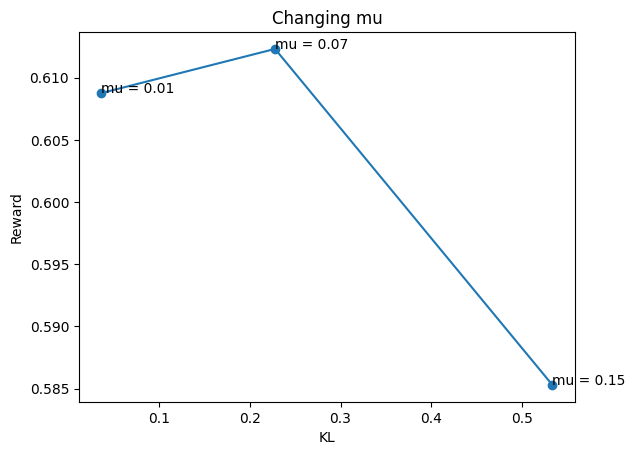

In [78]:
fig, ax = plt.subplots()
#ax.scatter(kl, rewards)
plt.plot(kl, rewards, '-o')
txts = ['mu = 0.01', 'mu = 0.07', 'mu = 0.15']
for i, txt in enumerate(txts):
    ax.annotate(txt, (kl[i], rewards[i]))
    
plt.xlabel('KL')
plt.ylabel('Reward')
plt.title('Changing mu')
plt.show()